In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import mplfinance as mpf
#from scipy.stats import kstest, norm
#from statsmodels.stats import shapiro
#from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [2]:
ticker = 'THRM.V'
#ticker = 'TSLA'
tkr = yf.Ticker(ticker)
ticker_1m = tkr.history(interval="1m", period='1d')
ticker_d = tkr.history(interval="1d", start='2018-01-01', end='2021-01-01')


In [3]:
# plt.style.use("ggplot")

In [4]:
print(ticker_1m.head(5))

                           Open  High   Low  Close  Volume  Dividends  \
Datetime                                                                
2021-02-05 09:30:00-05:00  0.49  0.50  0.49   0.50       0          0   
2021-02-05 09:31:00-05:00  0.50  0.51  0.50   0.51   14986          0   
2021-02-05 09:32:00-05:00  0.51  0.51  0.50   0.51   32900          0   
2021-02-05 09:33:00-05:00  0.51  0.51  0.51   0.51    3400          0   
2021-02-05 09:34:00-05:00  0.51  0.51  0.48   0.51  405481          0   

                           Stock Splits  
Datetime                                 
2021-02-05 09:30:00-05:00             0  
2021-02-05 09:31:00-05:00             0  
2021-02-05 09:32:00-05:00             0  
2021-02-05 09:33:00-05:00             0  
2021-02-05 09:34:00-05:00             0  


In [5]:
print(ticker_d.head())

             Open   High    Low  Close   Volume  Dividends  Stock Splits
Date                                                                    
2018-01-02  0.080  0.085  0.075  0.075   159666          0             0
2018-01-03  0.080  0.080  0.070  0.075   718160          0             0
2018-01-04  0.070  0.075  0.065  0.070   693152          0             0
2018-01-05  0.070  0.070  0.065  0.065   474965          0             0
2018-01-08  0.065  0.080  0.065  0.080  1068350          0             0


# 1. 1m data and VWAP

## Get 1-day trading data (open, close, high, low and volume) with 1 minute interval for Therma Bright Inc. (THRM.V).   

### Plot candle stick plot and VWAP in one figure using the 1-day data above.

Preparing vwap column

In [6]:
ticker_1m['avg_price'] = ticker_1m[['High','Low','Close']].mean(axis=1)
ticker_1m['avg_vol'] = ticker_1m['avg_price'] * ticker_1m['Volume']
ticker_1m['cum_vol'] = ticker_1m['Volume'].cumsum(axis=0)
ticker_1m['cum_avg_vol'] = ticker_1m['avg_vol'].cumsum(axis=0)
ticker_1m['vwap'] = ticker_1m['cum_avg_vol'] / ticker_1m['cum_vol']

Draw graph using mplfinance package

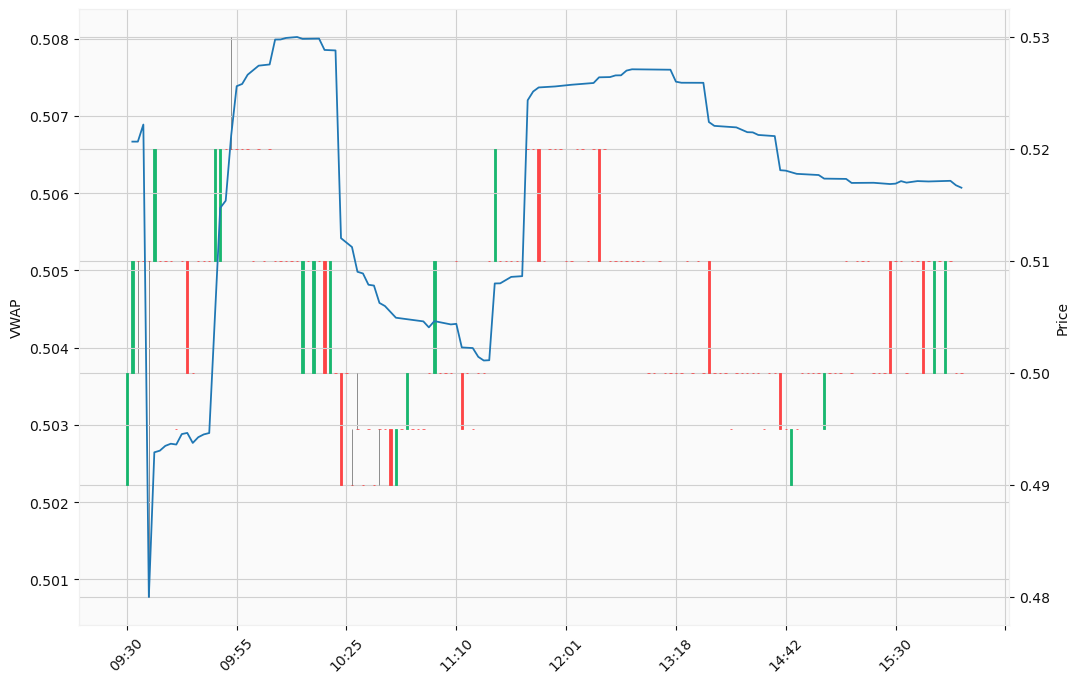

In [7]:
fig_1m = mpf.figure(figsize=(12,8), style="yahoo")
ax1_1m = fig_1m.add_subplot(1,1,1)
ax2_1m = ax1_1m.twinx()
ax2_1m.yaxis.set_label_position("left")
ax2_1m.yaxis.tick_left()
vwap = mpf.make_addplot(ticker_1m[["vwap"]], ax=ax2_1m, ylabel='VWAP')
mpf.plot(ticker_1m, ax=ax1_1m,addplot=vwap, type='candle')


# 2. Daily Plot and EMV

## Get daily trading data (open, close, high, low and volume) from 2018-01-01 to 2020-12-31 for Therma Bright Inc. (THRM.V).  

### Plot candle stick plot and 30-day and 100-day exponential moving averages on one figure.

In [8]:
ticker_d['EMA_30'] = ticker_d["Close"].ewm(span=30, adjust=False, min_periods=30).mean()
ticker_d['EMA_100'] = ticker_d["Close"].ewm(span=100, adjust=False, min_periods=100).mean()

In [9]:
print(ticker_d.tail(5))

             Open   High    Low  Close   Volume  Dividends  Stock Splits  \
Date                                                                       
2020-12-23  0.210  0.215  0.200  0.210  1138245          0             0   
2020-12-24  0.220  0.230  0.210  0.225  2114075          0             0   
2020-12-29  0.235  0.235  0.205  0.225  5004639          0             0   
2020-12-30  0.220  0.230  0.210  0.225  3156517          0             0   
2020-12-31  0.220  0.225  0.210  0.215  2197548          0             0   

              EMA_30   EMA_100  
Date                            
2020-12-23  0.157284  0.125665  
2020-12-24  0.161653  0.127632  
2020-12-29  0.165740  0.129560  
2020-12-30  0.169563  0.131450  
2020-12-31  0.172494  0.133105  


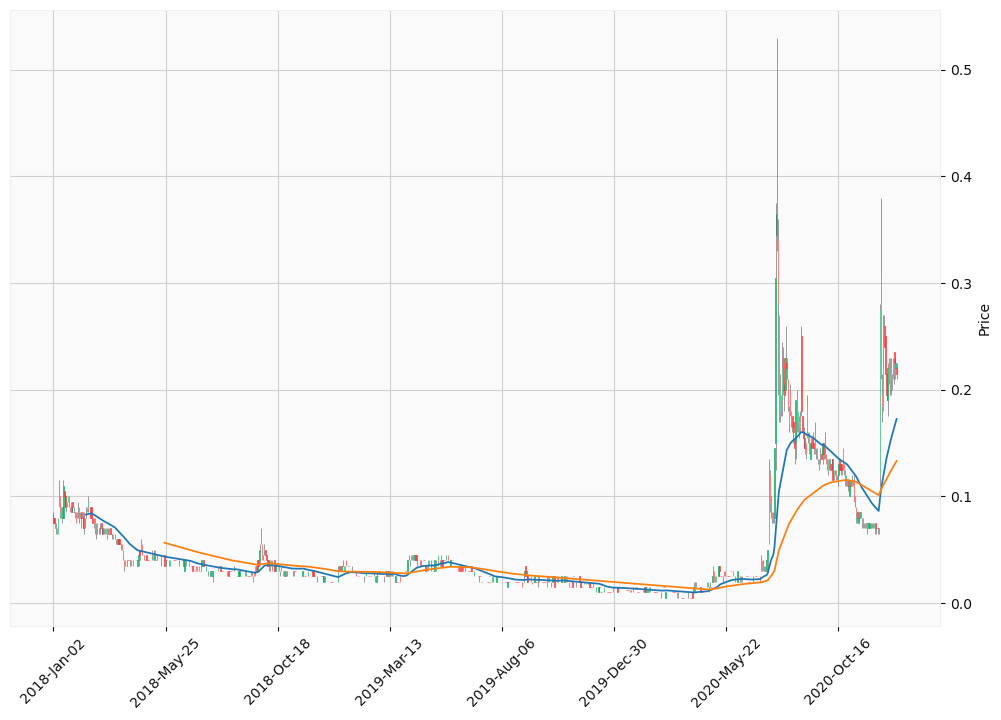

In [10]:
fig_d = mpf.figure(figsize=(12,8), style="yahoo")
ax1_d = fig_d.add_subplot(1,1,1)
#ax2_d = ax1_d.twinx()
#ax3_d = ax1_d.twinx()
#ax2_d.yaxis.set_label_position("left")
#ax2_d.yaxis.tick_left()
#ax3_d.yaxis.set_label_position("left")
#ax3_d.yaxis.tick_left()
ewm_30 = mpf.make_addplot(ticker_d[["EMA_30"]], ax=ax1_d, ylabel='ema_30')
ewm_100 = mpf.make_addplot(ticker_d[["EMA_100"]], ax=ax1_d, ylabel='ema_100')
mpf.plot(ticker_d, ax=ax1_d, addplot=[ewm_30, ewm_100], type='candle')


# 3. Daily Return and normal distribution

## Use the same data in Question 2. 

### Calculate daily return (return = log(today close/previous close))

In [11]:
ticker_d['prev_close'] = ticker_d.shift(1)['Close']


In [12]:
ticker_d['return'] = np.log(ticker_d['Close']/ticker_d['prev_close'])
ticker_d.drop(ticker_d.index[0], inplace=True)
print(ticker_d.head(5))

             Open   High    Low  Close   Volume  Dividends  Stock Splits  \
Date                                                                       
2018-01-03  0.080  0.080  0.070  0.075   718160          0             0   
2018-01-04  0.070  0.075  0.065  0.070   693152          0             0   
2018-01-05  0.070  0.070  0.065  0.065   474965          0             0   
2018-01-08  0.065  0.080  0.065  0.080  1068350          0             0   
2018-01-09  0.100  0.115  0.090  0.100  8806563          0             0   

            EMA_30  EMA_100  prev_close    return  
Date                                               
2018-01-03     NaN      NaN       0.075  0.000000  
2018-01-04     NaN      NaN       0.075 -0.068993  
2018-01-05     NaN      NaN       0.070 -0.074108  
2018-01-08     NaN      NaN       0.065  0.207639  
2018-01-09     NaN      NaN       0.080  0.223144  


<AxesSubplot:>

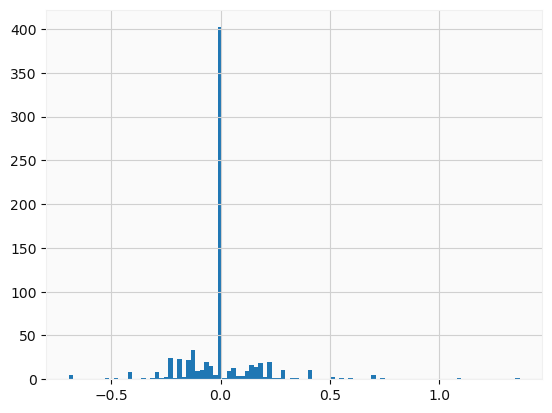

In [13]:
ticker_d['return'].hist(bins=100)

### Conduct the hypothesis testing to check if the distribution of daily return is normal.  

Use Shapiro-Wilk’s test for narmality testing, when p < 0.05 we can reject H0.

scipy module implementation H0 is this is normal distribution.

In [14]:
stat, p = shapiro(ticker_d['return'])
print(f"stat={stat}, p={p}")
if p > 0.05:
    print("Probably normal distribution")
else:
    print("Probably not normal distribution")

stat=0.7882537841796875, p=4.011051164214806e-30
Probably not normal distribution


# 4.S&P

## Take 10 stocks in S&P500 and collect daily close price from 2020-06-01 to 2020-12-31 for selected stocks. 

### Calculate daily return (return = log(today close/previous close)) for each of 10 stocks 

In [15]:
mmm = yf.Ticker("MMM").history(interval="1d", start='2020-06-01', end='2021-01-01')
aapl = yf.Ticker("AAPL").history(interval="1d", start='2020-06-01', end='2021-01-01')
amzn = yf.Ticker("AMZN").history(interval="1d", start='2020-06-01', end='2021-01-01')
ba = yf.Ticker("BA").history(interval="1d", start='2020-06-01', end='2021-01-01')
tsla = yf.Ticker("TSLA").history(interval="1d", start='2020-06-01', end='2021-01-01')
msft = yf.Ticker("MSFT").history(interval="1d", start='2020-06-01', end='2021-01-01')
fb = yf.Ticker("FB").history(interval="1d", start='2020-06-01', end='2021-01-01')
glw = yf.Ticker("GLW").history(interval="1d", start='2020-06-01', end='2021-01-01')
cost = yf.Ticker("COST").history(interval="1d", start='2020-06-01', end='2021-01-01')
ko = yf.Ticker("KO").history(interval="1d", start='2020-06-01', end='2021-01-01')

snp = yf.Ticker("^GSPC").history(interval="1d", start='2020-06-01', end='2021-01-01')

In [16]:
mmm['return'] = np.log(mmm['Close']/mmm.shift(1)['Close'])
aapl['return'] = np.log(aapl['Close']/aapl.shift(1)['Close'])
amzn['return'] = np.log(amzn['Close']/amzn.shift(1)['Close'])
ba['return'] = np.log(ba['Close']/ba.shift(1)['Close'])
tsla['return'] = np.log(tsla['Close']/tsla.shift(1)['Close'])
msft['return'] = np.log(msft['Close']/msft.shift(1)['Close'])
fb['return'] = np.log(fb['Close']/fb.shift(1)['Close'])
glw['return'] = np.log(glw['Close']/glw.shift(1)['Close'])
cost['return'] = np.log(cost['Close']/cost.shift(1)['Close'])
ko['return'] = np.log(ko['Close']/ko.shift(1)['Close'])

snp['return'] = np.log(snp['Close']/snp.shift(1)['Close'])


In [17]:
mmm.drop(mmm.index[0], inplace=True)
aapl.drop(aapl.index[0], inplace=True)
amzn.drop(amzn.index[0], inplace=True)
ba.drop(ba.index[0], inplace=True)
tsla.drop(tsla.index[0], inplace=True)
msft.drop(msft.index[0], inplace=True)
fb.drop(fb.index[0], inplace=True)
glw.drop(glw.index[0], inplace=True)
cost.drop(cost.index[0], inplace=True)
ko.drop(ko.index[0], inplace=True)

snp.drop(snp.index[0], inplace=True)

In [18]:
#mmm_return = mmm['return'].to_frame()
#mmm_return

In [19]:
daily_return = pd.concat(
    [mmm['return'].rename("mmm"),
    aapl['return'].rename("aapl"), 
    amzn['return'].rename("amzn"), 
    ba['return'].rename("ba"), 
    tsla['return'].rename("tsla"), 
    msft['return'].rename("msft"), 
    fb['return'].rename("fb"), 
    glw['return'].rename("glw"), 
    cost['return'].rename("cost"), 
    ko['return'].rename("ko")], axis=1)
daily_return

,mmm,aapl,amzn,ba,tsla,msft,fb,glw,cost,ko
Date,,,,,,,,,,
2020-06-02,0.013154,0.004619,0.000554,0.012603,-0.018588,0.011312,0.003487,0.048916,-0.003900,-0.001917
2020-06-03,0.022394,0.005490,0.002420,0.121754,0.001587,0.002431,-0.011061,0.051817,-0.001466,0.021098
2020-06-04,0.008278,-0.008649,-0.007208,0.062349,-0.021267,-0.013251,-0.016957,-0.016032,0.013314,0.000417
2020-06-05,0.029460,0.028083,0.009062,0.108540,0.024321,0.023129,0.019604,0.075089,0.004143,0.024123
2020-06-08,-0.003231,0.005895,0.016401,0.115146,0.070045,0.006177,0.002726,0.021873,-0.015665,0.015363
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.003042,0.007683,-0.003957,-0.011629,0.024150,0.007797,-0.002652,-0.002203,0.007406,0.006759
2020-12-28,0.001088,0.035141,0.034470,-0.004893,0.002897,0.009873,0.035272,-0.002208,0.017618,0.013383
2020-12-29,-0.004935,-0.013404,0.011517,0.000740,0.003459,-0.003607,-0.000795,-0.015314,0.004464,-0.000554


### (2)	Run PCA on calculated daily return and find the first principal component. 

In [20]:
pca = PCA(n_components=10)

In [21]:
# pca_mmm = PCA(n_components=5)
# pca_aapl = PCA(n_components=5)
# pca_amzn = PCA(n_components=5)
# pca_ba = PCA(n_components=5)
# pca_tsla = PCA(n_components=5)
# pca_msft = PCA(n_components=5)
# pca_fb = PCA(n_components=5)
# pca_glw = PCA(n_components=5)
# pca_cost = PCA(n_components=5)
# pca_ko = PCA(n_components=5)


In [22]:
pca.fit(daily_return)

PCA(n_components=10)

In [23]:
columns = ['pc%i' % i for i in range(1,11)]
df_pca = pd.DataFrame(pca.transform(daily_return), columns=columns, index=daily_return.index)
df_pca.head(5)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
Date,,,,,,,,,,
2020-06-02,0.005795,-0.031476,0.021248,0.032599,-0.009244,-0.001652,-0.021512,0.010578,0.004457,-0.006796
2020-06-03,-0.044702,-0.122712,-0.010258,-0.000003,-0.010904,-0.006466,-0.018841,-0.002035,0.002987,0.004224
2020-06-04,0.018260,-0.061263,-0.012109,-0.030996,-0.002508,-0.008435,0.007357,-0.009640,-0.020481,0.004524
2020-06-05,-0.083870,-0.105569,0.015189,0.022134,-0.007081,0.003692,-0.020948,0.009924,0.003013,0.000221
2020-06-08,-0.091800,-0.075211,-0.037772,-0.035479,0.004462,-0.005414,-0.021548,-0.001445,0.015967,0.000468


In [24]:
pca.components_[0]

array([-0.08929409, -0.29271678, -0.25267427, -0.33290634, -0.74649204,
       -0.24368176, -0.24556465, -0.18061873, -0.10086546, -0.10928134])

In [25]:
#snp = yf.Ticker("^GSPC").history(interval="1d", start='2020-06-01', end='2021-01-01')

In [26]:
df_pc1_snp = pd.DataFrame(snp["return"]).join(pd.DataFrame(df_pca["pc1"]))
df_pc1_snp.rename(columns={"return":"snp_return"}, inplace=True)
df_pc1_snp.reset_index(inplace=True)
df_pc1_snp.head(5)

,Date,snp_return,pc1
0,2020-06-02,0.008177,0.005795
1,2020-06-03,0.013557,-0.044702
2,2020-06-04,-0.003374,0.018260
3,2020-06-05,0.025874,-0.083870
4,2020-06-08,0.011970,-0.091800


In [27]:
# snp.tail()

### (3)	Plot first principal component and daily return of S&P500 in one figure

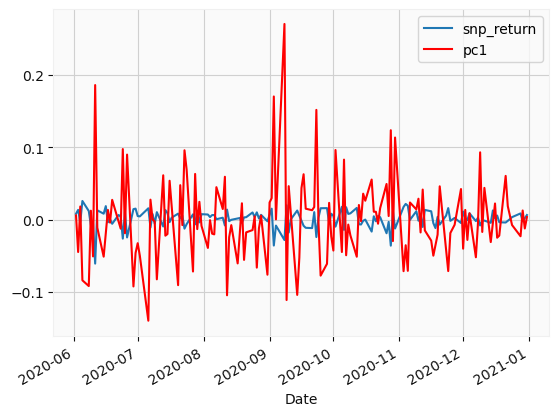

In [28]:
# fig_pc1_snp = mpf.figure(figsize=(12,8), style="yahoo")
# ax1_pc1_snp = fig_pc1_snp.add_subplot(1,1,1)
# #ax2_d = ax1_d.twinx()
# #ax3_d = ax1_d.twinx()
# #ax2_d.yaxis.set_label_position("left")
# #ax2_d.yaxis.tick_left()
# #ax3_d.yaxis.set_label_position("left")
# #ax3_d.yaxis.tick_left()
# pc_1 = mpf.make_addplot(df_pca[["pc1"]], ax=ax1_pc1_snp, ylabel='pc1')
# #ewm_100 = mpf.make_addplot(ticker_d[["EMA_100"]], ax=ax1_d, ylabel='ema_100')
# mpf.plot(pd.DataFrame(snp["return"]), ax=ax1_pc1_snp, addplot=[pc_1], type='line')

ax_pc1_snp = plt.gca()
df_pc1_snp.plot(kind='line', x='Date', y='snp_return', ax=ax_pc1_snp)
df_pc1_snp.plot(kind='line', x='Date', y='pc1', color='red', ax=ax_pc1_snp)

plt.show()

Correlation Analysis

### (4)	Calculate the correlation coefficient between first principal component and daily return of S&P500 index.

In [29]:
print("correlation coefficient is: ", df_pc1_snp['pc1'].corr(df_pc1_snp['snp_return']))



correlation coefficient is:  -0.7899621541652416
